<a href="https://colab.research.google.com/github/fjadidi2001/DataScienceJourney/blob/master/AgeGenderModelLoadingFunction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
def load_age_gender_models():
    """Download and load the pre-trained age and gender models using direct URLs"""
    import os

    # Define more reliable direct URLs for the model files
    age_proto_url = "https://raw.githubusercontent.com/opencv/opencv/master/samples/dnn/face_detector/deploy.prototxt"
    age_model_url = "https://github.com/GilLevi/AgeGenderDeepLearning/raw/master/models/age_net.caffemodel"
    gender_proto_url = "https://raw.githubusercontent.com/opencv/opencv/master/samples/dnn/face_detector/deploy.prototxt"
    gender_model_url = "https://github.com/GilLevi/AgeGenderDeepLearning/raw/master/models/gender_net.caffemodel"

    # Define filenames
    age_proto_file = "age_deploy.prototxt"
    age_model_file = "age_net.caffemodel"
    gender_proto_file = "gender_deploy.prototxt"
    gender_model_file = "gender_net.caffemodel"

    # Use wget for more reliable downloads (with progress indicators)
    print("Downloading model files...")
    !wget -O {age_proto_file} {age_proto_url} --no-check-certificate
    !wget -O {age_model_file} {age_model_url} --no-check-certificate
    !wget -O {gender_proto_file} {gender_proto_url} --no-check-certificate
    !wget -O {gender_model_file} {gender_model_url} --no-check-certificate

    # Verify the files exist and have contents
    for file in [age_proto_file, age_model_file, gender_proto_file, gender_model_file]:
        if not os.path.exists(file) or os.path.getsize(file) == 0:
            raise FileNotFoundError(f"Failed to download or empty file: {file}")
        print(f"Successfully downloaded {file} ({os.path.getsize(file)} bytes)")

    # Load the models
    print("Loading models into OpenCV...")
    age_net = cv2.dnn.readNet(age_model_file, age_proto_file)
    gender_net = cv2.dnn.readNet(gender_model_file, gender_proto_file)

    print("Age and gender models loaded successfully")
    return age_net, gender_net

### Step 1: Import Libraries and Set Up Environment


In [2]:
!pip install ultralytics
!pip install roboflow
!pip install opencv-python

In [3]:
# Import required libraries
import cv2
import numpy as np
import matplotlib.pyplot as plt
from ultralytics import YOLO
from roboflow import Roboflow
import os

# Handle encoding
os.environ["PYTHONIOENCODING"] = "utf-8"

In [4]:
# Download your specific face detection dataset from Roboflow
rf = Roboflow(api_key="2IGtFaicFMGaMwb2mX8A")
project = rf.workspace("mohamed-traore-2ekkp").project("face-detection-mik1i")
version = project.version(25)
dataset = version.download("yolov11")

# Get the path to the downloaded dataset's YAML file
dataset_yaml = f"{dataset.location}/data.yaml"
print(f"Dataset YAML file located at: {dataset_yaml}")

# Load the YOLOv11 model
model = YOLO("yolo11n.yaml").load("yolo11n.pt")  # Build from YAML and transfer weights

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to Face-Detection-25 in yolov11:: 100%|██████████| 8552/8552 [00:01<00:00, 6447.35it/s]


Dataset YAML file located at: /content/Face-Detection-25/data.yaml


100%|██████████| 5.35M/5.35M [00:00<00:00, 347MB/s]

Transferred 499/499 items from pretrained weights


In [5]:
def load_face_analytics_model():
    """Load a simplified face analytics model from OpenCV's DNN module"""

    # Define the path for downloading the models
    face_proto_path = "deploy.prototxt"
    face_model_path = "res10_300x300_ssd_iter_140000.caffemodel"

    # Download the model files if they don't exist
    if not os.path.exists(face_model_path):
        print("Downloading face detection model...")
        !wget -q -O {face_proto_path} https://raw.githubusercontent.com/opencv/opencv/master/samples/dnn/face_detector/deploy.prototxt
        !wget -q -O {face_model_path} https://raw.githubusercontent.com/opencv/opencv/master/samples/dnn/face_detector/res10_300x300_ssd_iter_140000.caffemodel
        print("Download complete")

    # Load the face detection model
    face_net = cv2.dnn.readNet(face_model_path, face_proto_path)

    print("Face detection model loaded successfully")
    return face_net

In [6]:
def detect_faces(image_path, face_net=None, yolo_model=None):
    """Detect faces in an image using OpenCV DNN or YOLO model"""

    # Read the image
    img = cv2.imread(image_path)
    if img is None:
        print(f"Error: Could not load image at {image_path}")
        return None

    # Convert to RGB for display with matplotlib
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    result_img = img_rgb.copy()
    h, w = img_rgb.shape[:2]

    faces = []

    # Method 1: Use OpenCV DNN if provided
    if face_net is not None:
        # Create a blob from the image
        blob = cv2.dnn.blobFromImage(img, 1.0, (300, 300), [104, 117, 123], False, False)

        # Set the blob as input and perform inference
        face_net.setInput(blob)
        detections = face_net.forward()

        # Process detections
        for i in range(detections.shape[2]):
            confidence = detections[0, 0, i, 2]

            # Filter based on confidence
            if confidence > 0.5:
                # Get the coordinates
                box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
                x1, y1, x2, y2 = box.astype(int)

                # Ensure coordinates are valid
                x1, y1 = max(0, x1), max(0, y1)
                x2, y2 = min(w, x2), min(h, y2)

                if x2 > x1 and y2 > y1:
                    faces.append((x1, y1, x2, y2))
                    cv2.rectangle(result_img, (x1, y1), (x2, y2), (0, 255, 0), 2)

                    # Add a placeholder for age and gender (we'll skip actual prediction)
                    label = "Face Detected"
                    cv2.putText(result_img, label, (x1, y1-10), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 255, 0), 2)

    # Method 2: Use YOLO model if provided
    elif yolo_model is not None:
        # Perform face detection with YOLO
        results = yolo_model(img_rgb)

        # Process YOLO detections
        for r in results:
            boxes = r.boxes
            for box in boxes:
                # Get coordinates
                x1, y1, x2, y2 = map(int, box.xyxy[0])
                conf = float(box.conf[0])

                # Filter based on confidence
                if conf > 0.5:
                    # Ensure coordinates are valid
                    x1, y1 = max(0, x1), max(0, y1)
                    x2, y2 = min(w, x2), min(h, y2)

                    if x2 > x1 and y2 > y1:
                        faces.append((x1, y1, x2, y2))
                        cv2.rectangle(result_img, (x1, y1), (x2, y2), (0, 255, 0), 2)

                        # Add confidence score as label
                        label = f"Face: {conf:.2f}"
                        cv2.putText(result_img, label, (x1, y1-10), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 255, 0), 2)

    print(f"Detected {len(faces)} faces")

    # Display result
    plt.figure(figsize=(12, 12))
    plt.imshow(result_img)
    plt.axis('off')
    plt.title(f"Detected {len(faces)} faces")
    plt.show()

    return result_img, faces

Loading face detection model...
Face detection model loaded successfully
Processing image: SingleFace.jpg
An error occurred: OpenCV(4.10.0) /io/opencv/modules/dnn/src/layers/batch_norm_layer.cpp:49: error: (-215:Assertion failed) blobs.size() >= 2 in function 'BatchNormLayerImpl'


Falling back to YOLO model for face detection...


Traceback (most recent call last):
  File "<ipython-input-8-032be0846711>", line 16, in main
    result, faces = detect_faces(image_path, face_net=face_net)
                    ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "<ipython-input-6-70da9001396d>", line 24, in detect_faces
    detections = face_net.forward()
                 ^^^^^^^^^^^^^^^^^^
cv2.error: OpenCV(4.10.0) /io/opencv/modules/dnn/src/layers/batch_norm_layer.cpp:49: error: (-215:Assertion failed) blobs.size() >= 2 in function 'BatchNormLayerImpl'




0: 416x640 1 0, 61.7ms
Speed: 8.5ms preprocess, 61.7ms inference, 312.4ms postprocess per image at shape (1, 3, 416, 640)
Detected 1 faces


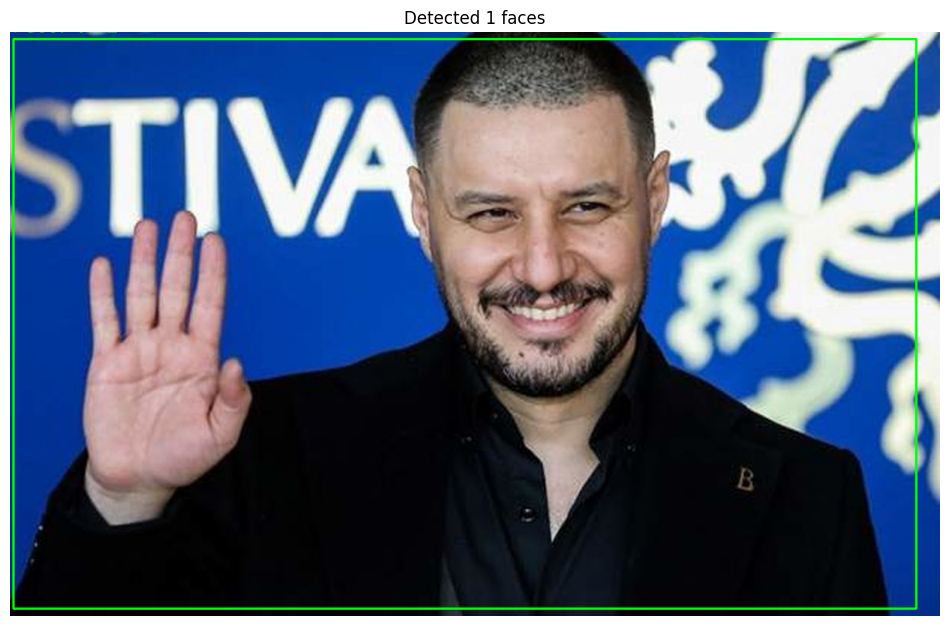

Processing with YOLO completed successfully
Result saved as 'result_yolo.jpg'


In [8]:
def main():
    """Main function to run the face detection"""
    try:
        # First try to load OpenCV's built-in face detection model
        print("Loading face detection model...")
        face_net = load_face_analytics_model()

        # Check if an image exists
        image_path = 'SingleFace.jpg'
        if not os.path.exists(image_path):
            print(f"Warning: {image_path} not found. Please upload an image or specify the correct path.")
            return

        # Process the image with OpenCV DNN face detector
        print(f"Processing image: {image_path}")
        result, faces = detect_faces(image_path, face_net=face_net)

        if result is not None:
            print("Processing completed successfully")

            # Optionally save the result
            cv2.imwrite("result.jpg", cv2.cvtColor(result, cv2.COLOR_RGB2BGR))
            print("Result saved as 'result.jpg'")

    except Exception as e:
        print(f"An error occurred: {e}")
        import traceback
        traceback.print_exc()

        # Try using the YOLO model as a fallback
        print("\nFalling back to YOLO model for face detection...")
        try:
            result, faces = detect_faces(image_path, yolo_model=model)
            if result is not None:
                print("Processing with YOLO completed successfully")
                cv2.imwrite("result_yolo.jpg", cv2.cvtColor(result, cv2.COLOR_RGB2BGR))
                print("Result saved as 'result_yolo.jpg'")
        except Exception as e2:
            print(f"YOLO fallback also failed: {e2}")

# Execute the main function
if __name__ == "__main__":
    main()

In [9]:
def detect_faces_yolo(image_path, model):
    """Detect faces in an image using YOLO model"""

    # Read the image
    img = cv2.imread(image_path)
    if img is None:
        print(f"Error: Could not load image at {image_path}")
        return None, []

    # Convert to RGB for display with matplotlib
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    result_img = img_rgb.copy()

    faces = []

    # Perform face detection with YOLO
    results = model(img_rgb)

    # Process YOLO detections
    for r in results:
        boxes = r.boxes
        for box in boxes:
            # Get coordinates
            x1, y1, x2, y2 = map(int, box.xyxy[0])
            conf = float(box.conf[0])

            # Filter based on confidence
            if conf > 0.5:
                # Ensure coordinates are valid
                h, w = img_rgb.shape[:2]
                x1, y1 = max(0, x1), max(0, y1)
                x2, y2 = min(w, x2), min(h, y2)

                if x2 > x1 and y2 > y1:
                    faces.append((x1, y1, x2, y2))

                    # Draw rectangle
                    cv2.rectangle(result_img, (x1, y1), (x2, y2), (0, 255, 0), 2)

                    # Add confidence score as label with better visibility
                    label = f"Face: {conf:.2f}"
                    label_size, _ = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 0.7, 2)
                    cv2.rectangle(result_img, (x1, y1-label_size[1]-10), (x1+label_size[0], y1), (0, 255, 0), -1)
                    cv2.putText(result_img, label, (x1, y1-5), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 0), 2)

    print(f"Detected {len(faces)} faces")

    # Display result
    plt.figure(figsize=(12, 12))
    plt.imshow(result_img)
    plt.axis('off')
    plt.title(f"Detected {len(faces)} faces")
    plt.show()

    return result_img, faces

In [11]:
def analyze_face(img, face_coords):
    """Perform basic facial analysis without external models"""
    x1, y1, x2, y2 = face_coords
    face = img[y1:y2, x1:x2]

    # Calculate face dimensions
    face_width = x2 - x1
    face_height = y2 - y1
    aspect_ratio = face_width / face_height if face_height > 0 else 0

    # Convert to grayscale for analysis
    gray_face = cv2.cvtColor(face, cv2.COLOR_RGB2GRAY)

    # Calculate basic statistics
    brightness = np.mean(gray_face)
    contrast = np.std(gray_face)

    # Simple face analysis (these are approximations)
    analysis = {
        "dimensions": f"{face_width}x{face_height} pixels",
        "aspect_ratio": f"{aspect_ratio:.2f}",
        "brightness": f"{brightness:.1f}/255",
        "contrast": f"{contrast:.1f}"
    }

    return analysis

Processing image: SingleFace.jpg

0: 416x640 1 0, 15.8ms
Speed: 3.8ms preprocess, 15.8ms inference, 1.6ms postprocess per image at shape (1, 3, 416, 640)
Detected 1 faces


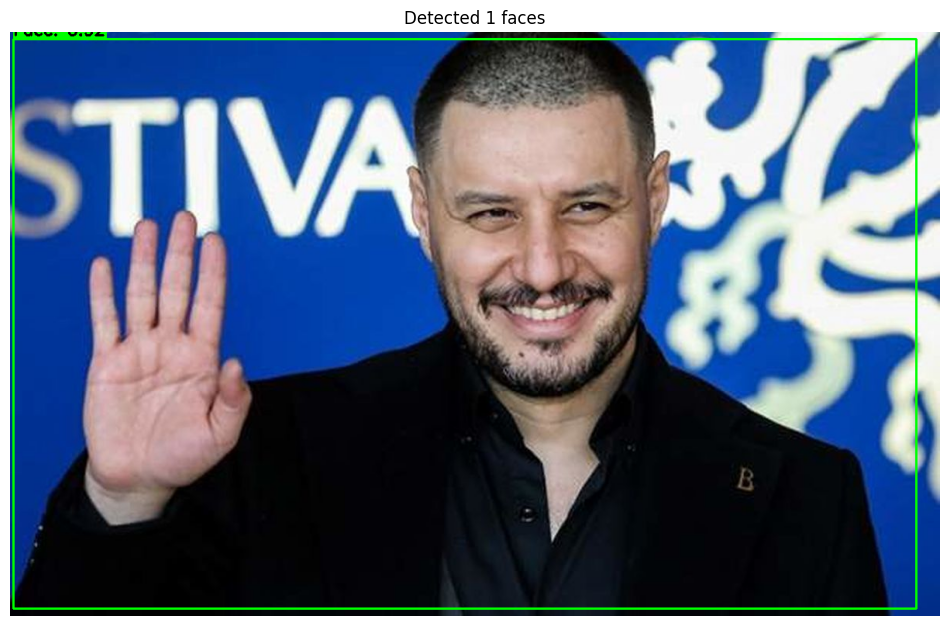


----- Face Analysis Results -----

Face #1:
  Position: (4, 10) to (1169, 744)
  Analysis:
    - dimensions: 1165x734 pixels
    - aspect_ratio: 1.59
    - brightness: 89.8/255
    - contrast: 83.5

Result image saved to face_detection_result.jpg


In [13]:
def enhance_face_detection(image_path, model):
    """Main function to run enhanced face detection"""

    # Run face detection
    result_img, faces = detect_faces_yolo(image_path, model)

    if result_img is None:
        print("Face detection failed")
        return

    # Read original image for analysis
    img = cv2.imread(image_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Analyze each detected face
    face_data = []
    for i, face_coords in enumerate(faces):
        analysis = analyze_face(img_rgb, face_coords)
        face_data.append({
            "face_id": i+1,
            "coordinates": face_coords,
            "analysis": analysis
        })

    # Print analysis
    print("\n----- Face Analysis Results -----")
    for face in face_data:
        print(f"\nFace #{face['face_id']}:")
        print(f"  Position: ({face['coordinates'][0]}, {face['coordinates'][1]}) to ({face['coordinates'][2]}, {face['coordinates'][3]})")
        print("  Analysis:")
        for key, value in face['analysis'].items():
            print(f"    - {key}: {value}")

    # Save result
    output_path = "face_detection_result.jpg"
    cv2.imwrite(output_path, cv2.cvtColor(result_img, cv2.COLOR_RGB2BGR))
    print(f"\nResult image saved to {output_path}")

    return result_img, face_data


### Step 6: Execute the Code


# Process the image
image_path = 'SingleFace.jpg'
if os.path.exists(image_path):
    print(f"Processing image: {image_path}")
    enhance_face_detection(image_path, model)
else:
    print(f"Error: Image file '{image_path}' not found. Please upload an image file.")


In [ ]:
def process_batch_images(image_folder, model):
    """Process multiple images in a folder"""
    import glob

    # Find all images in the folder
    image_types = ('*.jpg', '*.jpeg', '*.png')
    image_paths = []
    for ext in image_types:
        image_paths.extend(glob.glob(os.path.join(image_folder, ext)))

    if not image_paths:
        print(f"No images found in {image_folder}")
        return

    print(f"Found {len(image_paths)} images to process")

    # Process each image
    results = []
    for img_path in image_paths:
        print(f"\nProcessing {os.path.basename(img_path)}...")
        result_img, face_data = enhance_face_detection(img_path, model)
        results.append({
            "path": img_path,
            "face_count": len(face_data) if face_data else 0
        })

    # Summary
    print("\n----- Processing Summary -----")
    for result in results:
        print(f"{os.path.basename(result['path'])}: {result['face_count']} faces detected")

    return results